<a href="https://colab.research.google.com/github/shamim-hussain/wine-quality-classification-logistic-regression/blob/main/Wine_Quality_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wine Quality Classification
We will classifiy wines into either "good" or "bad" categories based on different chemical properties. It makes sense to do logistic regression for this problem because the features (chemical properties) should have approximately a positive/negative lenear correlation with the quality. The dataset - 

Dataset Link: https://archive.ics.uci.edu/ml/datasets/wine+quality

It is moderate in size, which is ideal for logistic regression, because more complicated models may overfit the data. The quality is given as a rank, although we can turn it into a binary target, i.e., bad/good.

# Download and Process the Dataset

## Download
We will be using the "white wine" dataset.

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

--2021-09-10 03:43:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264426 (258K) [application/x-httpd-php]
Saving to: ‘winequality-white.csv’

winequality-white.c 100%[===================>] 258.23K  1.26MB/s    in 0.2s    

2021-09-10 03:43:32 (1.26 MB/s) - ‘winequality-white.csv’ saved [264426/264426]



## Open dataset

In [15]:
import pandas as pd

dataset = pd.read_csv('winequality-white.csv', sep=';')
dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Let's check for missing data.

In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


No missing data. We also wanna know the min, max, std of the columns

In [17]:
dataset.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


# Splitting the dataset into train and test.

We will do a 80/20 split for train and test

In [34]:
# Shuffle the dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)

trainset_len = int(len(dataset)*.8)
trainset = dataset.iloc[:trainset_len].reset_index(drop=True)
testset = dataset.iloc[trainset_len:].reset_index(drop=True)

# Separate features and target and binarize target
We will predict the quality, but since we wish to explore a binary classification problem. The 50-percentile is 6 so we will assign qualities as such -

**Bad:0** -> When quality between 0-5

**Good:1** -> When quality between 6-9

Also convert everything to float while at it.

In [36]:
train_features = trainset.drop('quality', axis=1).astype('float32')
train_targets = (trainset['quality'] > 5).astype('float32')

test_features = testset.drop('quality', axis=1).astype('float32')
test_targets = (testset['quality'] > 5).astype('float32')

# Standardizing input features

Let's have a look at the distributions of the training features.

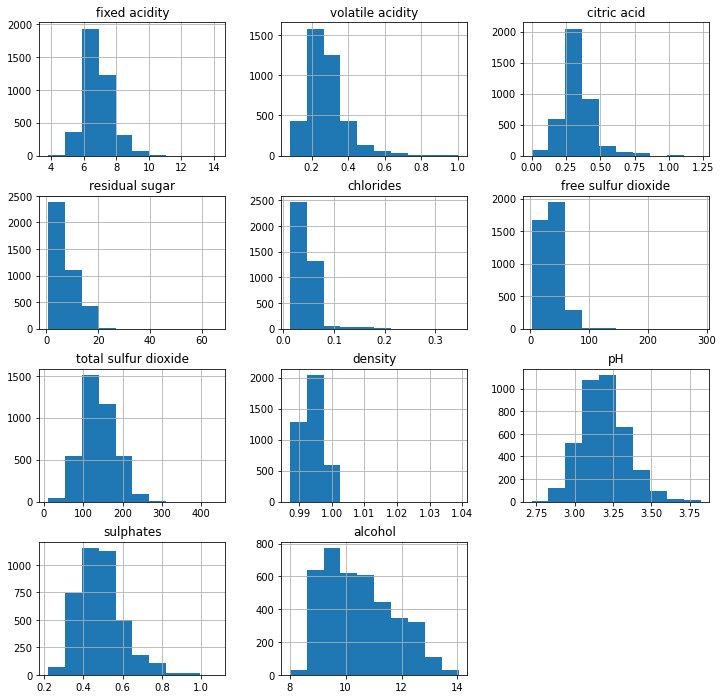

In [41]:
plots = train_features.hist(figsize=[12,12])

Very different distributions. So we standardize them before training.

In [42]:
feat_mean = train_features.mean()
feat_std = train_features.std()

train_features = (train_features - feat_mean)/feat_std
test_features = (test_features - feat_mean)/feat_std


Plot them again

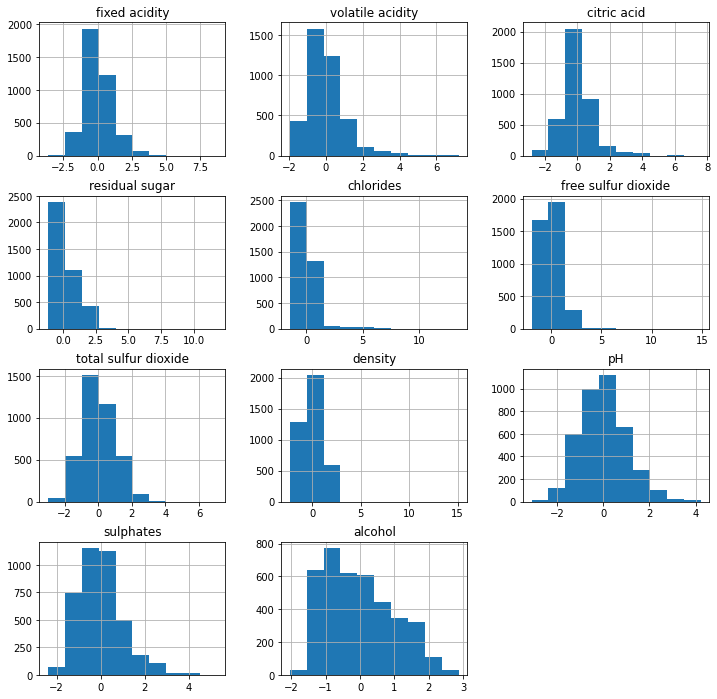

In [43]:
plots = train_features.hist(figsize=[12,12])

Looks better. Now to convert them to numpy arrays.

In [45]:
X_train = train_features.values
Y_train = train_targets.values

X_test = test_features.values
Y_test = test_targets.values

# Logistic Regression

Let us first write a function to calculate the loss and also the gradient of the loss.

In [85]:
import numpy as np

def sigmoid(x):
    return 1/(1+np.exp(-x))

def predict(w,b,X):
    return sigmoid(np.dot(X,w) + b)

# Cost function
def loss(Y,A,eps=1e-7):
    A_cliped = np.clip(A, eps, 1-eps)
    return -np.mean(Y * np.log(A) + (1-Y) * (np.log(1-A)))

def gradients(X,Y,A):
    dw = np.dot(X.T, A-Y)/X.shape[0]
    db = np.mean(A-Y)
    return dw, db

def accuracy(Y_true, Y_pred):
    return np.mean((Y_true==Y_pred).astype('float32'))


# Batch Gradient Descent

100%|██████████| 5000/5000 [00:01<00:00, 3046.81it/s]


Weights: [-0.06174603 -0.6427972   0.02835472  0.5877932   0.02887898  0.16200893
 -0.10275589 -0.35207963  0.0880068   0.15806429  1.0985469 ]
Bias: 0.888016828019169


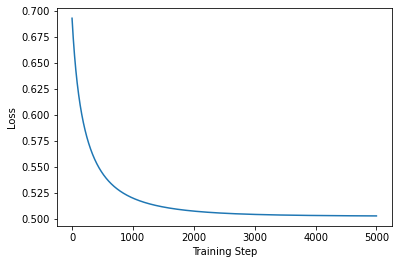

In [146]:
from tqdm import tqdm
import matplotlib.pyplot as plt


num_steps = 5000
learning_rate = 0.01

num_features = X_train.shape[1]
w = np.zeros((num_features,), dtype='float32')
b = np.array(0., dtype='float32')

loss_at_step_batch = np.zeros((num_steps,),dtype='float32')
X = X_train
Y = Y_train
for step in tqdm(range(num_steps)):
    A = predict(w,b,X)
    loss_at_step_batch[step] = loss(Y, A)
    dw, db = gradients(X,Y,A)
    w[()] = w - learning_rate*dw
    b = b - learning_rate*db

print(f'Weights: {w}')
print(f'Bias: {b}')

plt.figure()
plt.plot(loss_at_step_batch)
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.show()

## Results

In [147]:
pred_train = predict(w,b, X_train)
pred_test = predict(w,b, X_test)

loss_train_batch = loss(Y_train, pred_train)
loss_test_batch = loss(Y_test, pred_test)
acc_train_batch = accuracy(Y_train, np.round(pred_train))
acc_test_batch = accuracy(Y_test, np.round(pred_test))

print(f'Training loss = {loss_train_batch:0.4f}')
print(f'Test loss = {loss_test_batch:0.4f}')
print()
print(f'Training accuracy = {acc_train_batch:0.3%}')
print(f'Test accuracy = {acc_test_batch:0.3%}')

Training loss = 0.5027
Test loss = 0.5105

Training accuracy = 75.523%
Test accuracy = 75.000%


# Mini-batch Gradient Descent

100%|██████████| 5000/5000 [00:01<00:00, 2902.70it/s]


Weights: [-0.06247187 -0.64415544  0.02774066  0.5876234   0.02907478  0.16219005
 -0.10280962 -0.35190463  0.08869807  0.15853503  1.0993003 ]
Bias: 0.8868606121093053


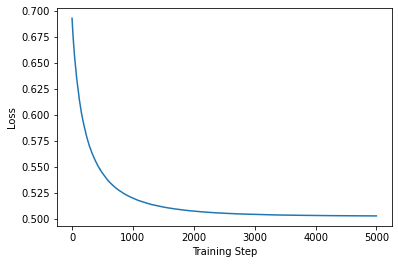

In [148]:
from tqdm import tqdm
import matplotlib.pyplot as plt


num_steps = 5000
batch_size = 64
learning_rate = 0.01

num_features = X_train.shape[1]
w = np.zeros((num_features,), dtype='float32')
b = np.array(0., dtype='float32')

loss_at_step_minibatch = np.zeros((num_steps,),dtype='float32')


indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
batch_end = batch_size
for step in tqdm(range(num_steps)):
    batch_indices = indices[batch_end-batch_size:batch_end]
    X = X_train[batch_indices]
    Y = Y_train[batch_indices]

    loss_at_step_minibatch[step] = loss(Y_train, predict(w,b,X_train))
    A = predict(w,b,X)
    dw, db = gradients(X,Y,A)
    w[()] = w - learning_rate*dw
    b = b - learning_rate*db

    batch_end += batch_size
    if batch_end > X_train.shape[0]:
        np.random.shuffle(indices)
        batch_end = batch_size


print(f'Weights: {w}')
print(f'Bias: {b}')

plt.figure()
plt.plot(loss_at_step_minibatch)
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.show()

## Results

In [149]:
pred_train = predict(w,b, X_train)
pred_test = predict(w,b, X_test)

loss_train_minibatch = loss(Y_train, pred_train)
loss_test_minibatch = loss(Y_test, pred_test)
acc_train_minibatch = accuracy(Y_train, np.round(pred_train))
acc_test_minibatch = accuracy(Y_test, np.round(pred_test))

print(f'Training loss = {loss_train_minibatch:0.4f}')
print(f'Test loss = {loss_test_minibatch:0.4f}')
print()
print(f'Training accuracy = {acc_train_minibatch:0.3%}')
print(f'Test accuracy = {acc_test_minibatch:0.3%}')

Training loss = 0.5027
Test loss = 0.5105

Training accuracy = 75.549%
Test accuracy = 75.000%


# RMSprop

100%|██████████| 5000/5000 [00:28<00:00, 172.72it/s]


Weights: [-0.04141116 -0.6657034   0.02443708  0.6760607   0.05160675  0.16173674
 -0.08567817 -0.44716737  0.10856364  0.16805725  1.1132402 ]
Bias: 0.9033374190330505


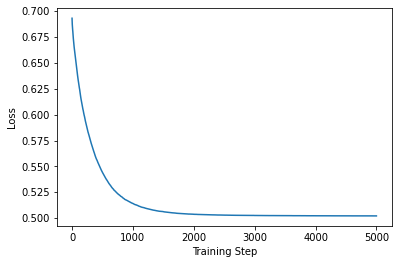

In [152]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

num_steps = 5000
batch_size = 64
learning_rate = 0.001
rmsprop_rho = 0.9
rmsprop_epsilon = 1e-7

num_features = X_train.shape[1]
w_tf = tf.Variable(np.zeros((num_features,), dtype='float32'), trainable=True)
b_tf = tf.Variable(np.array(0., dtype='float32'), trainable=True)
w = w_tf.numpy()
b = b_tf.numpy()

loss_at_step_rmsprop = np.zeros((num_steps,),dtype='float32')

optim = RMSprop(learning_rate = learning_rate,
                rho = rmsprop_rho,
                epsilon = rmsprop_epsilon)


indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
batch_end = batch_size
for step in tqdm(range(num_steps)):
    batch_indices = indices[batch_end-batch_size:batch_end]
    X = X_train[batch_indices]
    Y = Y_train[batch_indices]

    loss_at_step_rmsprop[step] = loss(Y_train, predict(w,b,X_train))
    A = predict(w,b,X)
    dw, db = gradients(X,Y,A)
    optim.apply_gradients([(dw,w_tf),(db,b_tf)])
    w = w_tf.numpy()
    b = b_tf.numpy()

    batch_end += batch_size
    if batch_end > X_train.shape[0]:
        np.random.shuffle(indices)
        batch_end = batch_size


print(f'Weights: {w}')
print(f'Bias: {b}')


plt.figure()
plt.plot(loss_at_step_rmsprop)
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.show()

## Results

In [153]:
pred_train = predict(w,b, X_train)
pred_test = predict(w,b, X_test)

loss_train_rmsprop = loss(Y_train, pred_train)
loss_test_rmsprop = loss(Y_test, pred_test)
acc_train_rmsprop = accuracy(Y_train, np.round(pred_train))
acc_test_rmsprop = accuracy(Y_test, np.round(pred_test))

print(f'Training loss = {loss_train_rmsprop:0.4f}')
print(f'Test loss = {loss_test_rmsprop:0.4f}')
print()
print(f'Training accuracy = {acc_train_rmsprop:0.3%}')
print(f'Test accuracy = {acc_test_rmsprop:0.3%}')

Training loss = 0.5023
Test loss = 0.5114

Training accuracy = 75.625%
Test accuracy = 75.306%


# Adam

100%|██████████| 5000/5000 [00:19<00:00, 258.58it/s]


Weights: [-0.03438729 -0.6609281   0.02461974  0.70140624  0.04605846  0.14744464
 -0.08359383 -0.4875627   0.11747873  0.1675234   1.084534  ]
Bias: 0.8998722434043884


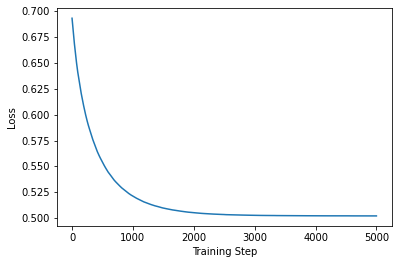

In [158]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

num_steps = 5000
batch_size = 64
learning_rate = 0.001
adam_beta1 = 0.9
adam_beta2 = 0.999
adam_epsilon = 1e-7

num_features = X_train.shape[1]
w_tf = tf.Variable(np.zeros((num_features,), dtype='float32'), trainable=True)
b_tf = tf.Variable(np.array(0., dtype='float32'), trainable=True)
w = w_tf.numpy()
b = b_tf.numpy()

loss_at_step_adam = np.zeros((num_steps,),dtype='float32')

optim = Adam(learning_rate = learning_rate,
             beta_1 = adam_beta1,
             beta_2 = adam_beta2,
             epsilon = adam_epsilon)


indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
batch_end = batch_size
for step in tqdm(range(num_steps)):
    batch_indices = indices[batch_end-batch_size:batch_end]
    X = X_train[batch_indices]
    Y = Y_train[batch_indices]

    loss_at_step_adam[step] = loss(Y_train, predict(w,b,X_train))
    A = predict(w,b,X)
    dw, db = gradients(X,Y,A)
    optim.apply_gradients([(dw,w_tf),(db,b_tf)])
    w = w_tf.numpy()
    b = b_tf.numpy()

    batch_end += batch_size
    if batch_end > X_train.shape[0]:
        np.random.shuffle(indices)
        batch_end = batch_size

print(f'Weights: {w}')
print(f'Bias: {b}')

plt.figure()
plt.plot(loss_at_step_adam)
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.show()

## Results

In [157]:
pred_train = predict(w,b, X_train)
pred_test = predict(w,b, X_test)

loss_train_adam = loss(Y_train, pred_train)
loss_test_adam = loss(Y_test, pred_test)
acc_train_adam = accuracy(Y_train, np.round(pred_train))
acc_test_adam = accuracy(Y_test, np.round(pred_test))

print(f'Training loss = {loss_train_adam:0.4f}')
print(f'Test loss = {loss_test_adam:0.4f}')
print()
print(f'Training accuracy = {acc_train_adam:0.3%}')
print(f'Test accuracy = {acc_test_adam:0.3%}')

Training loss = 0.5022
Test loss = 0.5118

Training accuracy = 75.421%
Test accuracy = 74.490%


# Comparisons

## Analysis of convergence

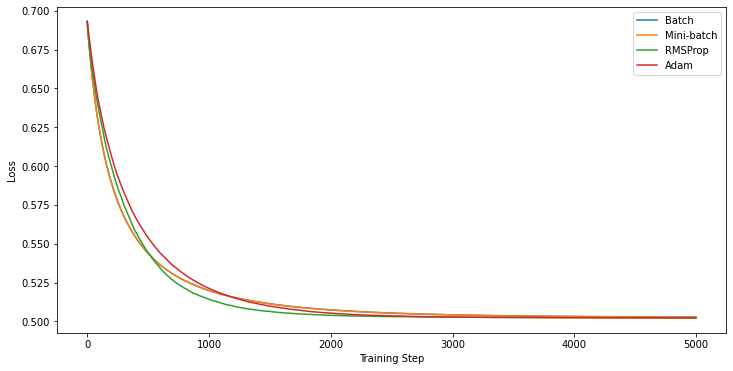

In [160]:
plt.figure(figsize=[12,6])
plt.plot(loss_at_step_batch, label='Batch')
plt.plot(loss_at_step_minibatch, label='Mini-batch')
plt.plot(loss_at_step_rmsprop, label='RMSProp')
plt.plot(loss_at_step_adam, label='Adam')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Comments
* For this simple problem, all of the optimizers performed almost equally well. However, for the default hyperparameters RMSprop acheived the fastest convergence. So, we can recommend RMSprop opimizer for this problem.
* With a big enough batch size (64) mini-batch gradient descent performs just as good as batch gradient descent, while being more computationally efficient. So, it is preferable to batch gradient descent.

# Analysis of Results

In [177]:
print('Optimizer\tTraining Loss\tTest Loss\tTraining Accuracy\tTest Accuracy')
print('---------\t-------------\t---------\t-----------------\t-------------')
print(f'Batch\t\t{loss_train_batch:0.4f}\t\t{loss_test_batch:0.4f}\t\t{acc_train_batch:0.3%}\t\t\t{acc_test_batch:0.3%}')
print(f'Mini-batch\t{loss_train_minibatch:0.4f}\t\t{loss_test_minibatch:0.4f}\t\t{acc_train_minibatch:0.3%}\t\t\t{acc_test_minibatch:0.3%}')
print(f'RMSprop\t\t{loss_train_rmsprop:0.4f}\t\t{loss_test_rmsprop:0.4f}\t\t{acc_train_rmsprop:0.3%}\t\t\t{acc_test_rmsprop:0.3%}')
print(f'Adam\t\t{loss_train_adam:0.4f}\t\t{loss_test_adam:0.4f}\t\t{acc_train_adam:0.3%}\t\t\t{acc_test_adam:0.3%}')

Optimizer	Training Loss	Test Loss	Training Accuracy	Test Accuracy
---------	-------------	---------	-----------------	-------------
Batch		0.5027		0.5105		75.523%			75.000%
Mini-batch	0.5027		0.5105		75.549%			75.000%
RMSprop		0.5023		0.5114		75.625%			75.306%
Adam		0.5022		0.5118		75.421%			74.490%


### Comments
Almost all of the optimizers seem to acheive the same results. Although Adam seems to overfit the data a bit. However, it acheives the lowest training loss. This may also be a statistical fluke. So, we cannot recomment one optimizer over another from a results standpoint.